In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import xgboost as xgb

import scipy.stats as stats 
from scipy.stats import chi2_contingency, boxcox

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

In [117]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')

In [118]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [120]:
df.duplicated().sum()

np.int64(562)

In [121]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [122]:
df[df.Age > 60]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
114,63,140,90,15.0,98.0,90,high risk
313,62,120,80,6.9,98.0,66,low risk
322,65,90,60,6.9,98.0,70,low risk
326,66,85,60,6.9,98.0,86,low risk
338,70,85,60,6.9,102.0,70,low risk
339,65,120,90,6.9,103.0,76,low risk
435,65,130,80,15.0,98.0,86,high risk
502,63,140,90,15.0,98.0,90,high risk


In [123]:
len(df[df.Age < 13])

39

In [124]:
df.BodyTemp.value_counts()

BodyTemp
98.0     804
101.0     98
102.0     66
100.0     20
103.0     13
99.0      10
98.4       2
98.6       1
Name: count, dtype: int64

Data cleaning

In [125]:
data = df.copy()

In [126]:
data = data.drop_duplicates().reset_index(drop=True)

In [127]:
df.shape, data.shape

((1014, 7), (452, 7))

In [128]:
data.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [129]:
data.HeartRate.mode()

0    70
Name: HeartRate, dtype: int64

In [130]:
data.loc[data.HeartRate == 7, "HeartRate"] = 70

In [131]:
data.RiskLevel.unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [132]:
data.replace({"high risk": 2, "low risk": 0, "mid risk": 1}, inplace=True)

data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


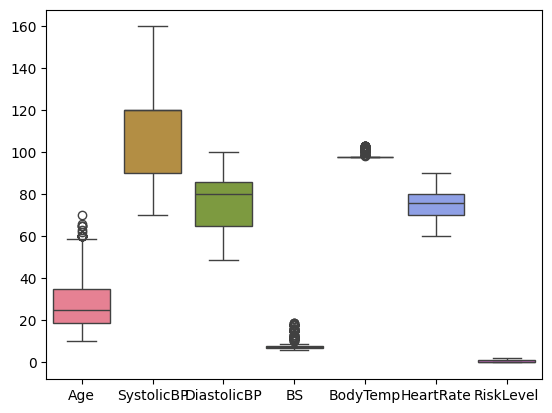

In [133]:
sns.set_palette("viridis")


sns.boxplot(data);

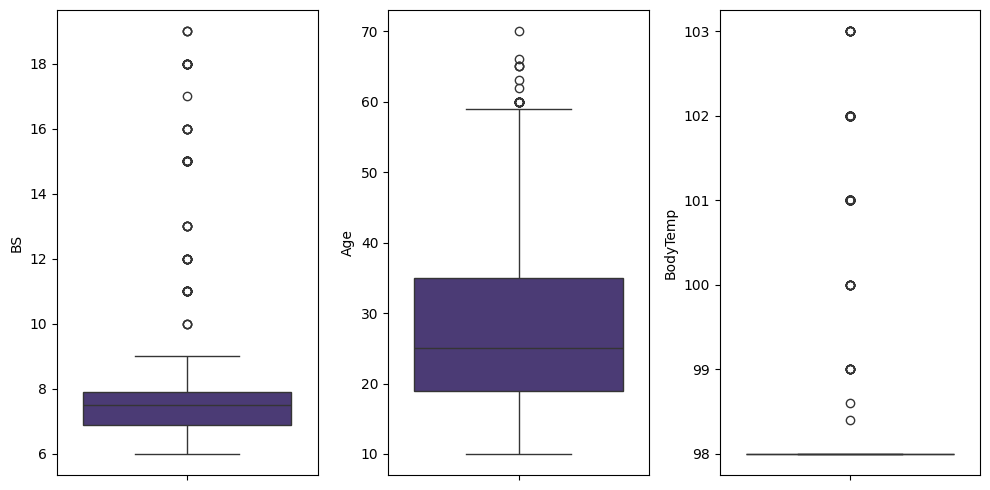

In [134]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
sns.boxplot(y = 'BS', data = data)
plt.subplot(1,3,2)
sns.boxplot(y = 'Age', data = data)
plt.subplot(1,3,3)
sns.boxplot(y = 'BodyTemp', data = data)

plt.tight_layout()
plt.show();

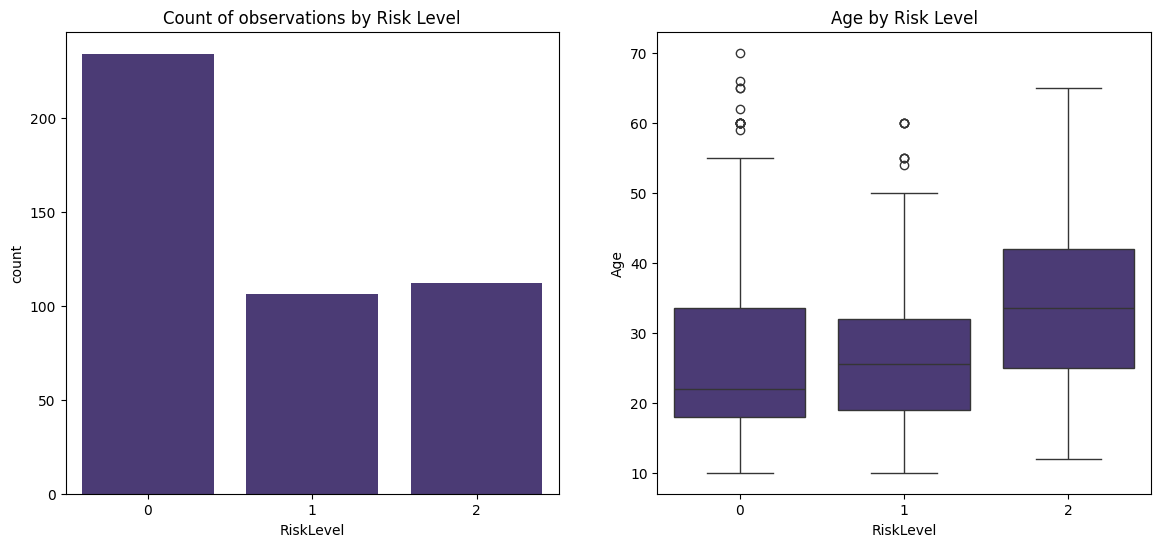

In [135]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.countplot(ax=axes[0], x=data.RiskLevel)
axes[0].set_title("Count of observations by Risk Level")

sns.boxplot(ax=axes[1], x=data.RiskLevel, y=data.Age)
axes[1].set_title("Age by Risk Level");

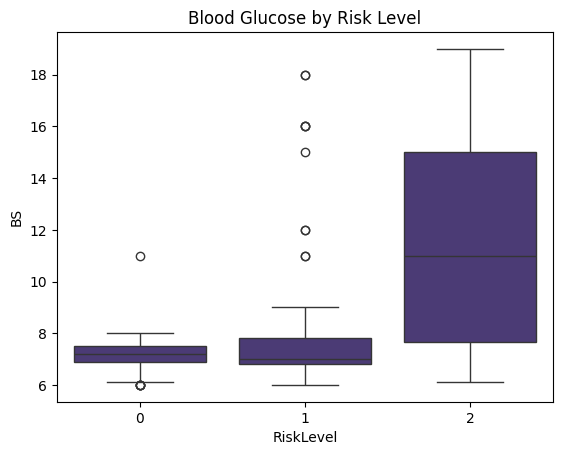

In [136]:
sns.boxplot(x=data.RiskLevel, y=data.BS).set_title("Blood Glucose by Risk Level");

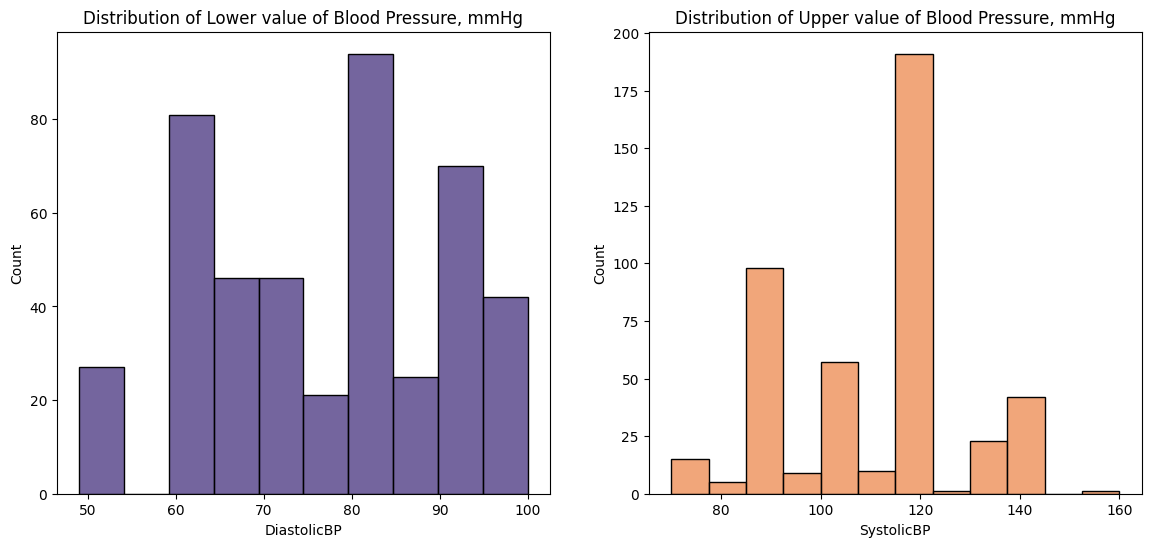

In [137]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.histplot(ax=axes[0], x=data.DiastolicBP)
axes[0].set_title("Distribution of Lower value of Blood Pressure, mmHg")

sns.histplot(ax=axes[1], x=data.SystolicBP, color="#ed894e")
axes[1].set_title("Distribution of Upper value of Blood Pressure, mmHg");

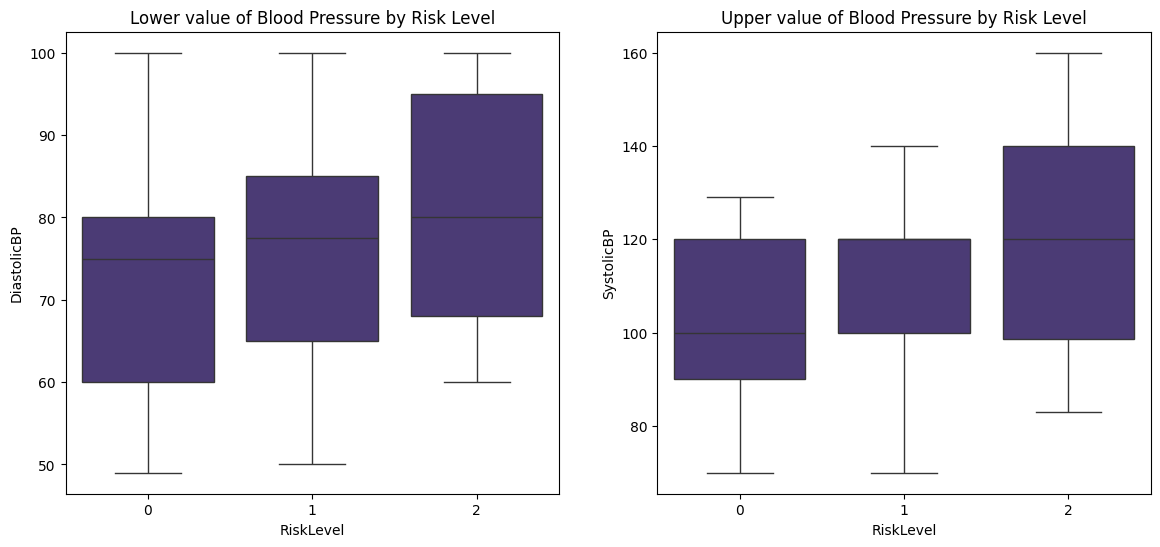

In [138]:


fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.boxplot(ax=axes[0], x=data.RiskLevel, y=data.DiastolicBP)
axes[0].set_title("Lower value of Blood Pressure by Risk Level")

sns.boxplot(ax=axes[1], x=data.RiskLevel, y=data.SystolicBP)
axes[1].set_title("Upper value of Blood Pressure by Risk Level");



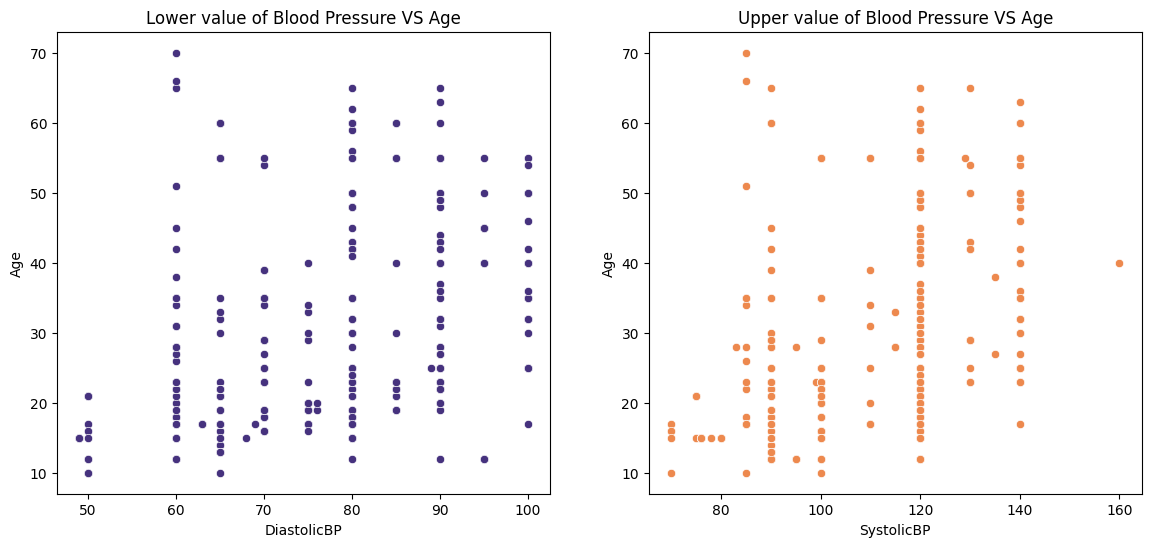

In [139]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.scatterplot(x=data.DiastolicBP, y=data.Age, ax=axes[0])
axes[0].set_title("Lower value of Blood Pressure VS Age")

sns.scatterplot(ax=axes[1], x=data.SystolicBP, y=data.Age, color="#ed894e")
axes[1].set_title("Upper value of Blood Pressure VS Age");

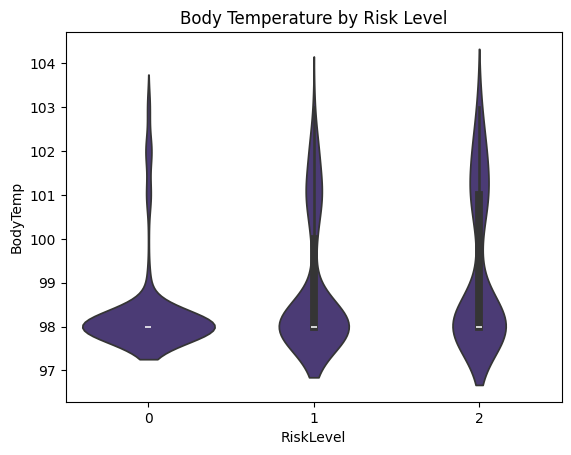

In [140]:
sns.violinplot(y=data.BodyTemp, x=data.RiskLevel).set_title("Body Temperature by Risk Level");

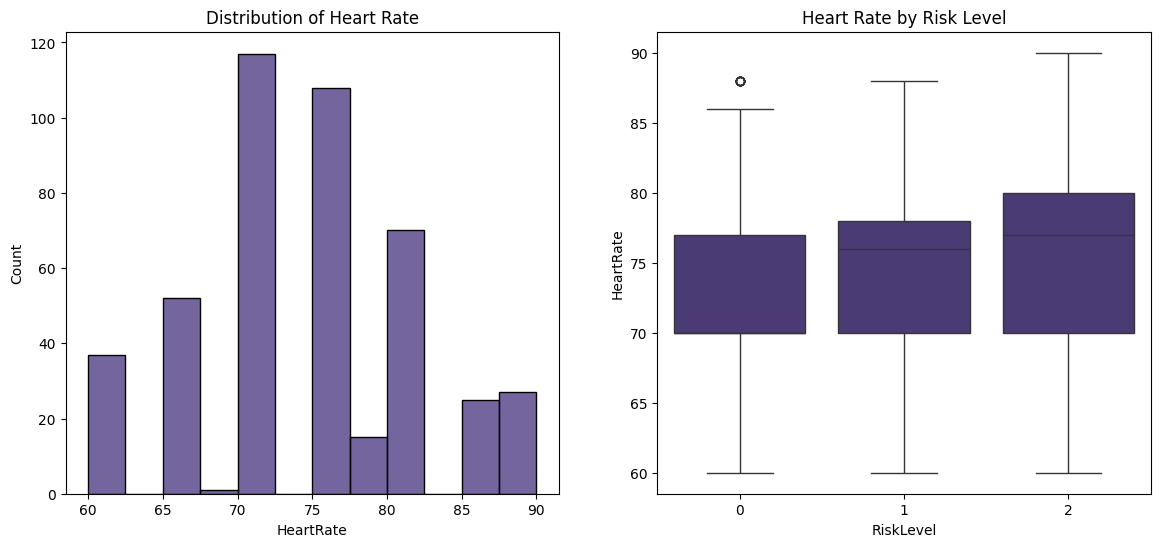

In [141]:


fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.histplot(ax=axes[0], x=data.HeartRate)
axes[0].set_title("Distribution of Heart Rate")

sns.boxplot(ax=axes[1], x=data.RiskLevel, y=data.HeartRate)
axes[1].set_title("Heart Rate by Risk Level");



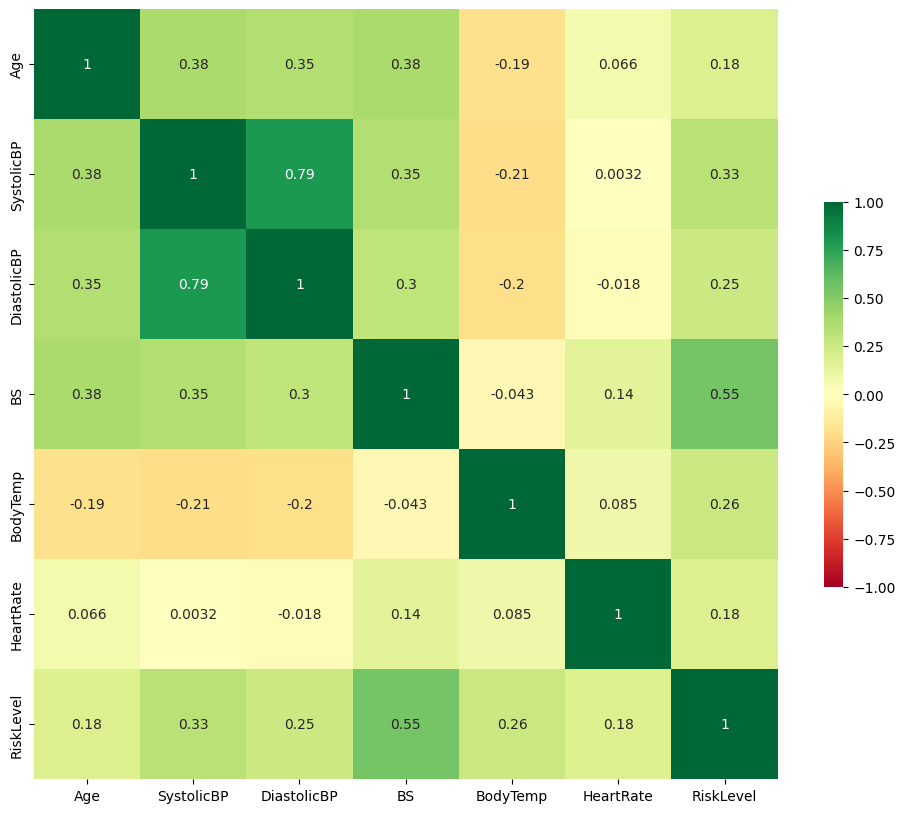

In [142]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn', vmin=-1, center=0,
           cbar_kws={"shrink": .5})

plt.show()

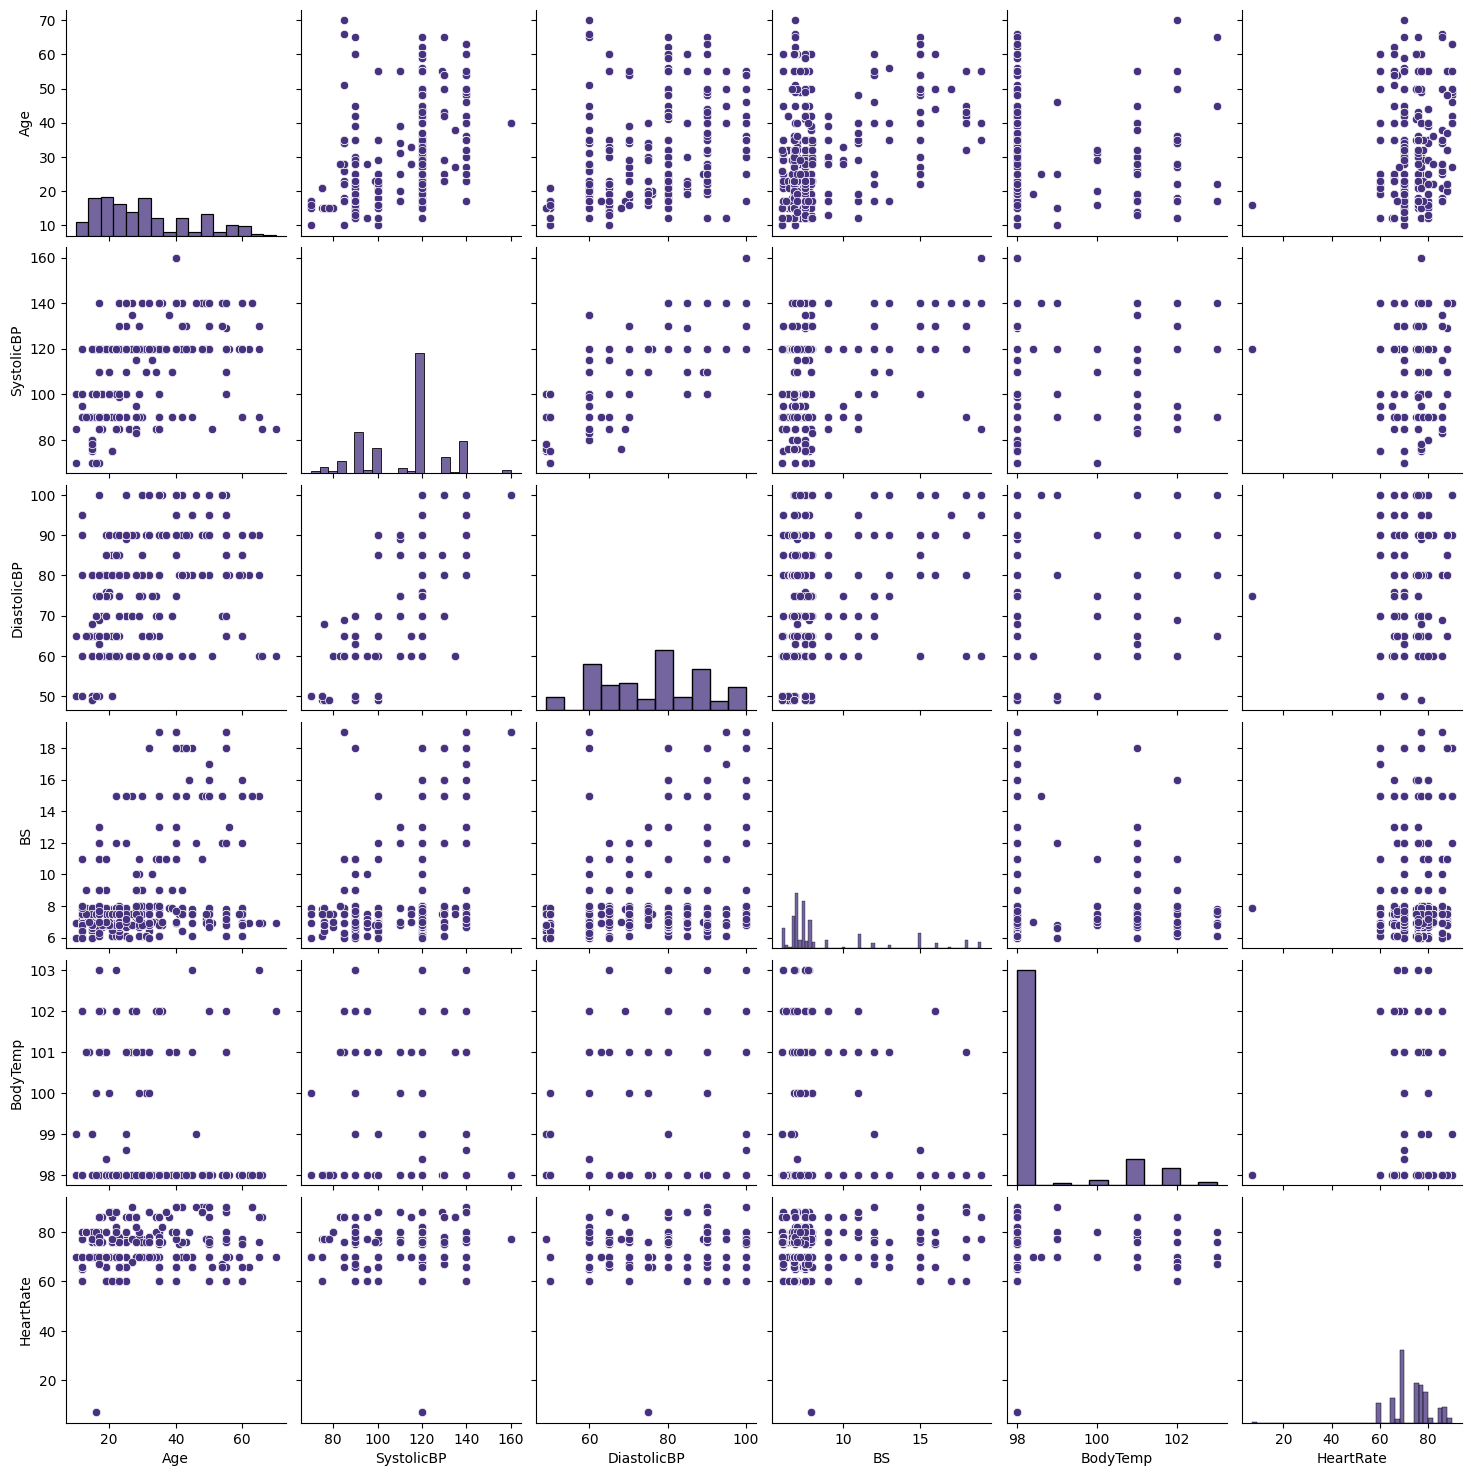

In [143]:
sns.pairplot(df);

In [144]:
skew_limit = 0.75 # define a limit above which we will log transform

# Create a list of numerical colums to check for skewing
mask = df.dtypes != object
num_cols = df.columns[mask]

skew_vals = data[num_cols].skew()

In [145]:


# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols



,Skew
BS,2.262874
BodyTemp,1.751794
Age,0.922079


0.197419127736239


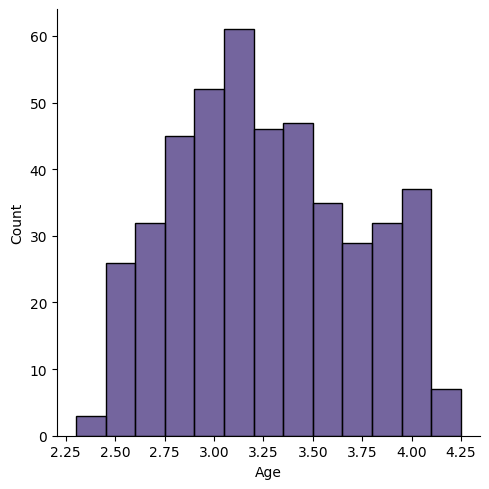

In [146]:
df_transformed = data.copy()

df_transformed["Age"] = data["Age"].apply(np.log)
print(df_transformed["Age"].skew())
sns.displot(df_transformed.Age);

In [147]:


bc_result = boxcox(data.BS)
boxcox_bs = pd.DataFrame(bc_result[0], columns=['BS'])
lambd = bc_result[1]

lambd

np.float64(-3.3440041657535655)

BS    0.264687
dtype: float64


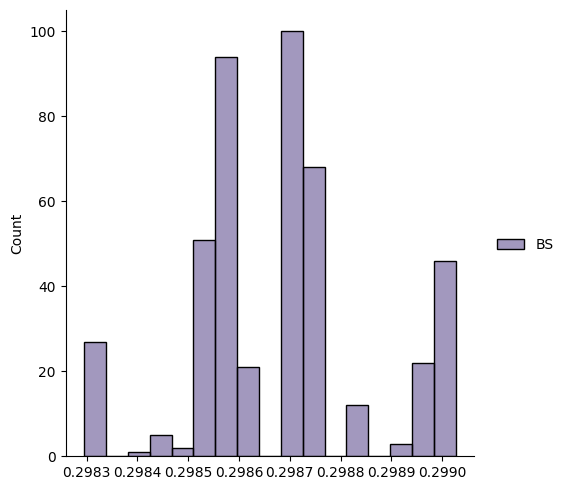

In [148]:
print(boxcox_bs.skew())
sns.displot(boxcox_bs);

In [149]:


df_transformed['BS'] = boxcox_bs['BS']


df_transformed[['BS', 'Age']].skew().to_frame().rename(columns={0:'Skew'}).sort_values('Skew', ascending=False)




,Skew
BS,0.264687
Age,0.197419


In [150]:


X = df_transformed.drop('RiskLevel', axis=1)
y = df_transformed['RiskLevel']



In [151]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101, stratify=y)

In [153]:
# Create and fit a KNN model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Make predictions on the test data
knn_preds = knn.predict(X_test)

In [154]:


print('K Nearest Neighbors K=1')
print('\n')
print(confusion_matrix(y_test,knn_preds))
print('\n')
print(classification_report(y_test,knn_preds))



K Nearest Neighbors K=1


[[48 18  4]
 [17  8  7]
 [ 5 10 19]]


              precision    recall  f1-score   support

           0       0.69      0.69      0.69        70
           1       0.22      0.25      0.24        32
           2       0.63      0.56      0.59        34

    accuracy                           0.55       136
   macro avg       0.51      0.50      0.50       136
weighted avg       0.56      0.55      0.56       136



In [155]:


error_rate = []

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))



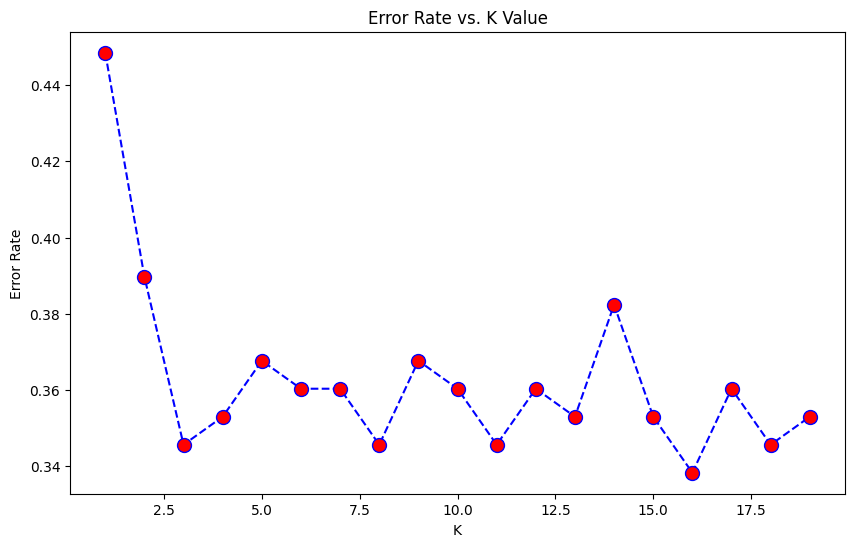

In [156]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), error_rate, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

In [157]:
knn = KNeighborsClassifier(n_neighbors=16)

knn.fit(X_train,y_train)
knn_preds = knn.predict(X_test)

print('K Nearest Neighbors K=16')
print('\n')
print(confusion_matrix(y_test,knn_preds))
print('\n')
print(classification_report(y_test,knn_preds))

K Nearest Neighbors K=16


[[62  6  2]
 [20  6  6]
 [ 9  3 22]]


              precision    recall  f1-score   support

           0       0.68      0.89      0.77        70
           1       0.40      0.19      0.26        32
           2       0.73      0.65      0.69        34

    accuracy                           0.66       136
   macro avg       0.60      0.57      0.57       136
weighted avg       0.63      0.66      0.63       136



In [158]:


# Define class weights
class_weight = {0: 0.2, 1: 0.4, 2: 0.4}



In [159]:


# Create and fit a SVC model
svc = SVC(class_weight=class_weight)
svc.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
svcKernel_pred = svc.predict(X_test)

# Evaluate the model
print('Support Vector Machine')
print('\n')
print(confusion_matrix(y_test, svcKernel_pred))
print("\n")
print(classification_report(y_test, svcKernel_pred))



Support Vector Machine


[[59  7  4]
 [17  7  8]
 [ 3  6 25]]


              precision    recall  f1-score   support

           0       0.75      0.84      0.79        70
           1       0.35      0.22      0.27        32
           2       0.68      0.74      0.70        34

    accuracy                           0.67       136
   macro avg       0.59      0.60      0.59       136
weighted avg       0.64      0.67      0.65       136



In [160]:
# create a Random Forest Classifier
forest = RandomForestClassifier(class_weight=class_weight)

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 25, 30],
    'min_samples_leaf': [2, 3, 5] 
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_forest.fit(X_train, y_train)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_forest.best_params_)
print('Best Accuracy: ', grid_search_forest.best_score_)

# get the best model
best_forest = grid_search_forest.best_estimator_

Best Parameters:  {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 500}
Best Accuracy:  0.7059027777777779


In [161]:
forest_pred = grid_search_forest.predict(X_test)



print('Random Forest')
print('\n')
print(confusion_matrix(y_test, forest_pred))
print('\n')
print(classification_report(y_test, forest_pred))



Random Forest


[[61  6  3]
 [16 10  6]
 [ 3  3 28]]


              precision    recall  f1-score   support

           0       0.76      0.87      0.81        70
           1       0.53      0.31      0.39        32
           2       0.76      0.82      0.79        34

    accuracy                           0.73       136
   macro avg       0.68      0.67      0.66       136
weighted avg       0.71      0.73      0.71       136



In [169]:
!pip install --upgrade xgboost scikit-learn

In [172]:
under_30 = data.loc[data.Age < 30]
under_30_risk = under_30.RiskLevel
under_mean = under_30_risk.mean()
under_mean

np.float64(0.5878136200716846)

In [174]:


over_30 = data.loc[data.Age >= 30]
over_30_risk = over_30.RiskLevel
over_mean = over_30_risk.mean()
over_mean



np.float64(0.9595375722543352)

In [175]:
data['IsOver30'] = [1 if x >= 30 else 0 for x in data['Age']]

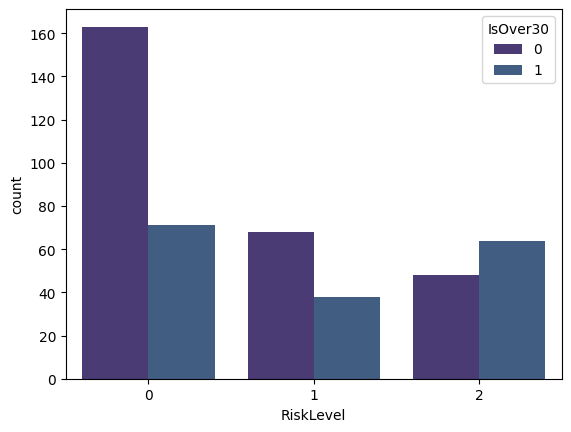

In [176]:
sns.countplot(data=data, x='RiskLevel', hue='IsOver30');

In [177]:


contingency= pd.crosstab(data.RiskLevel, data.IsOver30)
contingency



IsOver30,0,1
RiskLevel,,
0,163,71
1,68,38
2,48,64


In [178]:
chi2, p_val, dof, exp_freq = chi2_contingency(contingency, correction = False)
print('chi-square statistic: {} , p_value: {} , degree of freedom: {} ,expected frequencies: {} '.format(chi2, p_val, dof, exp_freq))

chi-square statistic: 23.374318560745017 , p_value: 8.40100446268846e-06 , degree of freedom: 2 ,expected frequencies: [[144.4380531   89.5619469 ]
 [ 65.42920354  40.57079646]
 [ 69.13274336  42.86725664]] 


In [179]:


if (p_val < 0.05):
    print('Reject the null hypothesis that the risk level of pregnancy does not depend on age of a woman.')
else:
    print('We failed to reject the null hypothesis that the risk level of pregnancy does not depend on age of a woman.')



Reject the null hypothesis that the risk level of pregnancy does not depend on age of a woman.
